In [2]:

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from ipywidgets import interact
import nibabel as nib

import pydicom
import scipy.ndimage
# import gdcm

import glob

from skimage import measure 
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage.morphology import disk, opening, closing
from tqdm import tqdm

from IPython.display import HTML
from PIL import Image

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import os
from pathlib import Path
import pydicom

In [ ]:
# Function to load and sort DICOM slices robustly
def load_scans(dcm_path):
    # List all .dcm files in the directory
    files = [os.path.join(dcm_path, f) for f in os.listdir(dcm_path) if f.lower().endswith('.dcm')]
    
    # Read only DICOMs that contain pixel data (skip reports, RTSTRUCT, etc.)
    slices = []
    for f in files:
        ds = pydicom.dcmread(f)
        if hasattr(ds, "PixelData"):
            slices.append(ds)

    # Define a safe sort key
    def sort_key(ds):
        if hasattr(ds, "ImagePositionPatient") and ds.ImagePositionPatient is not None:
            return float(ds.ImagePositionPatient[2])
        elif hasattr(ds, "SliceLocation"):
            return float(ds.SliceLocation)
        elif hasattr(ds, "InstanceNumber"):
            return int(ds.InstanceNumber)
        else:
            return 0  # fallback if nothing is available

    # Sort slices
    slices.sort(key=sort_key)

    return slices

root = Path(r"PATIENTS_DICOM_STRUCTURE")

# For testing: set to a patient ID or None for all
test_patient = None  # e.g., "ID0001"

all_series = []

for patient in sorted(os.listdir(root)):
    if test_patient and patient != test_patient:
        continue
    patient_path = root / patient
    if not patient_path.is_dir():
        continue

    # Each subfolder is a scan date (baseline or follow-up)
    for date_folder in sorted(os.listdir(patient_path)):
        date_path = patient_path / date_folder
        if not date_path.is_dir():
            continue

        # Each date folder has one or more series folders
        for series_folder in sorted(os.listdir(date_path)):
            series_path = date_path / series_folder
            if not series_path.is_dir():
                continue

            # Collect all DICOM files in this series
            dicoms = [f for f in series_path.iterdir() if f.suffix.lower() == ".dcm"]
            if dicoms:
                all_series.append({
                    "patient_id": patient,
                    "scan_date": date_folder,
                    "series_path": series_path,
                    "dicom_files": dicoms
                })

print(f"Found {len(all_series)} series")
print("Example:", all_series[0]["series_path"] if all_series else "No series found")
series_path = all_series[0]["series_path"]
scans = load_scans(series_path)
print(f"Loaded {len(scans)} DICOM slices.")
print(scans[2])  # Print the first slice's metadata for verification




Found 142 series
Example: PATIENTS_DICOM_STRUCTURE/865785/baseline_1969-10-06/1.2.392.200036.9116.2.6.1.3268.2047398422.1583821116.160520
Loaded 310 DICOM slices.
Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 224
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.392.200036.9116.2.6.1.3268.2047398422.1583821163.307192
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.826.0.1.3680043.214.1
(0002, 0013) Implementation Version Name         SH: '1.2.0.0'
(0002, 0016) Source Application Entity Title     AE: 'VIDA Lambda Anonymizer'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: ['ISO 2022 IR 13', 'ISO 2022 IR 87']
(0008, 0008) Image Type                    

In [ ]:
# Convert pixel arrays to Hounsfield Units (HU)

def set_outside_scanner_to_air(raw_pixelarrays):
    raw_pixelarrays[raw_pixelarrays <= -1500] = 0
    return raw_pixelarrays

def transform_to_hu(slices):
    images = np.stack([file.pixel_array for file in slices])
    images = images.astype(np.int16)
    print(images)

    #images = set_outside_scanner_to_air(images)
    
    # convert to HU
    for n in range(len(slices)):
        
        intercept = slices[n].RescaleIntercept
        slope = slices[n].RescaleSlope
        
        if slope != 1:
            images[n] = slope * images[n].astype(np.float64)
            images[n] = images[n].astype(np.int16)
            
        images[n] += np.int16(intercept)
     #Clip    
    # images = np.clip(images, a_min = -1000,a_max = 1000)
    return np.array(images, dtype=np.int16)

# Usage example:
hu_scans = transform_to_hu(scans)
print(hu_scans)  # (num_slices, height, width)
print(np.min(hu_scans), np.max(hu_scans))
from ctviewer import CTViewer
  # assuming that volumetric_image is the 3-dimensional numpy array
CTViewer(hu_scans)

[[[-2048 -2048 -2048 ... -2048 -2048 -2048]
  [-2048 -2048 -2048 ... -2048 -2048 -2048]
  [-2048 -2048 -2048 ... -2048 -2048 -2048]
  ...
  [-2048 -2048 -2048 ... -2048 -2048 -2048]
  [-2048 -2048 -2048 ... -2048 -2048 -2048]
  [-2048 -2048 -2048 ... -2048 -2048 -2048]]

 [[-2048 -2048 -2048 ... -2048 -2048 -2048]
  [-2048 -2048 -2048 ... -2048 -2048 -2048]
  [-2048 -2048 -2048 ... -2048 -2048 -2048]
  ...
  [-2048 -2048 -2048 ... -2048 -2048 -2048]
  [-2048 -2048 -2048 ... -2048 -2048 -2048]
  [-2048 -2048 -2048 ... -2048 -2048 -2048]]

 [[-2048 -2048 -2048 ... -2048 -2048 -2048]
  [-2048 -2048 -2048 ... -2048 -2048 -2048]
  [-2048 -2048 -2048 ... -2048 -2048 -2048]
  ...
  [-2048 -2048 -2048 ... -2048 -2048 -2048]
  [-2048 -2048 -2048 ... -2048 -2048 -2048]
  [-2048 -2048 -2048 ... -2048 -2048 -2048]]

 ...

 [[-2048 -2048 -2048 ... -2048 -2048 -2048]
  [-2048 -2048 -2048 ... -2048 -2048 -2048]
  [-2048 -2048 -2048 ... -2048 -2048 -2048]
  ...
  [-2048 -2048 -2048 ... -2048 -2048 -20

interactive(children=(RadioButtons(description='Slice plane selection:', index=2, options=('y-z', 'z-x', 'x-y'…

In [ ]:

def get_original_spacing(scans):

    slice_thickness = float(scans[0].SliceThickness)
    pixel_spacing = [float(sp) for sp in scans[0].PixelSpacing]  # [row_spacing, col_spacing]

    # Return as (z, y, x)
    return (slice_thickness, pixel_spacing[0], pixel_spacing[1])
slice_thickness, spacing_y, spacing_x =  get_original_spacing(scans)
import numpy as np
affine = np.diag([spacing_x, spacing_y, slice_thickness, 1])

nifti_img = nib.Nifti1Image(hu_scans.astype(np.int16), affine)



In [ ]:

nifti_spacing = nifti_img.header.get_zooms()

print("NIfTI spacing:", nifti_spacing)

# Check intensity range
data = nifti_img.get_fdata()
print("HU range:", np.min(data), "to", np.max(data))

NameError: name 'nifti_img' is not defined

Original CT shape: (284, 512, 512)
Original CT spacing: (1.25, 0.703125, 0.703125)
Original mask shape: (284, 512, 512)
Original mask spacing: (1.25, 0.703125, 0.703125)

✅ After resampling:
CT shape: (355, 360, 360) spacing: (1.0, 1.0, 1.0)
Mask shape: (355, 360, 360) spacing: (1.0, 1.0, 1.0)


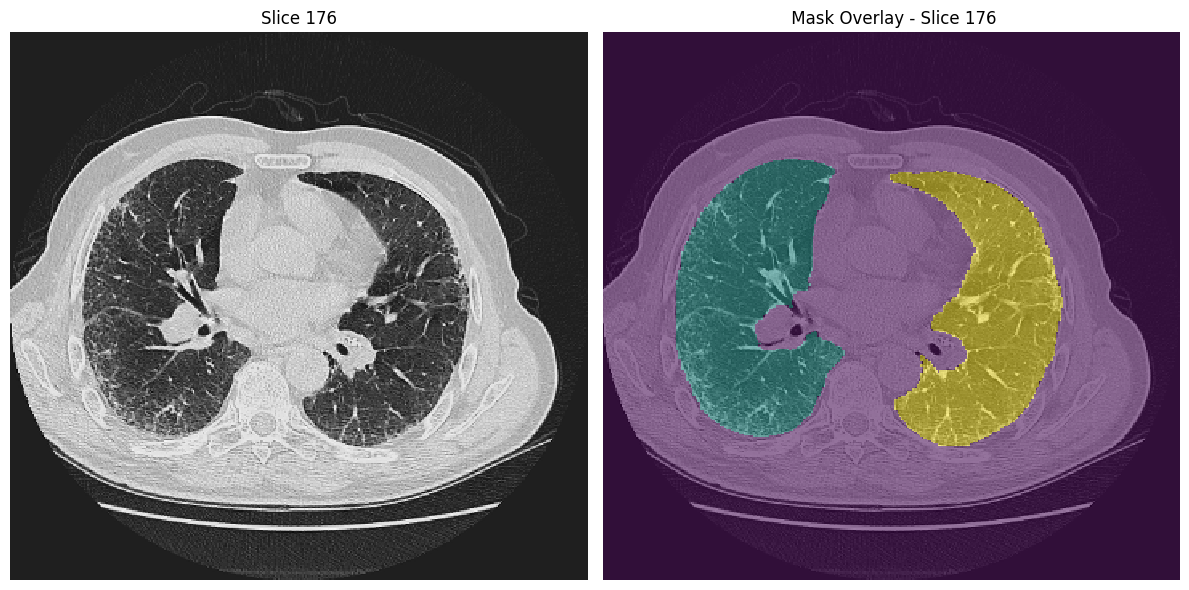

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
import SimpleITK as sitk
import ipywidgets as widgets
from ipywidgets import interact

# ============================================================
# ✅ Resampling utilities (same as your pipeline)
# ============================================================
def resample_volume(ct_array, original_spacing, new_spacing=(1, 1, 1), interpolator=sitk.sitkBSpline):
    """
    Resample a 3D numpy CT volume to new spacing (default 1mm isotropic).
    original_spacing and new_spacing must be in (z, y, x) order.
    """
    image_itk = sitk.GetImageFromArray(ct_array)

    # SimpleITK expects spacing in (x, y, z)
    image_itk.SetSpacing(tuple(float(s) for s in original_spacing[::-1]))

    original_size = np.array(image_itk.GetSize(), dtype=np.int32)
    original_spacing_np = np.array(original_spacing, dtype=np.float64)
    new_spacing_np = np.array(new_spacing, dtype=np.float64)

    # Compute new size
    new_size = np.round(original_size * (original_spacing_np[::-1] / new_spacing_np[::-1])).astype(int)

    resampler = sitk.ResampleImageFilter()
    resampler.SetOutputSpacing(tuple(float(s) for s in new_spacing_np[::-1]))
    resampler.SetSize([int(s) for s in new_size])
    resampler.SetOutputDirection(image_itk.GetDirection())
    resampler.SetOutputOrigin(image_itk.GetOrigin())
    resampler.SetInterpolator(interpolator)

    resampled_itk = resampler.Execute(image_itk)
    resampled_array = sitk.GetArrayFromImage(resampled_itk)

    # Convert spacing back to (z, y, x)
    actual_spacing = resampled_itk.GetSpacing()[::-1]

    return resampled_array, actual_spacing


def get_spacing_from_nifti(nii):
    """Return spacing in (z, y, x) order."""
    zooms = nii.header.get_zooms()[:3]  # (x, y, z)
    return (zooms[2], zooms[1], zooms[0])


# ============================================================
# ✅ Load CT and Mask
# ============================================================
nifti_path = "/scratch/bds/OSIC/PATIENTS_DICOM_STRUCTURE_MAIN/1002385/baseline_1975-02-01/1002385_baseline_1975-02-01_NIfTY/1002385_baseline_1975-02-01.nii.gz"
mask_path  = "/scratch/bds/OSIC/PATIENTS_DICOM_STRUCTURE_MAIN/1002385/baseline_1975-02-01/1002385_baseline_1975-02-01_Mask/1002385_baseline_1975-02-01_mask.nii.gz"

# Load CT
nii_ct = nib.load(nifti_path)
ct_array = nii_ct.get_fdata().astype(np.int16)
ct_spacing = get_spacing_from_nifti(nii_ct)

print(f"Original CT shape: {ct_array.shape}")
print("Original CT spacing:", ct_spacing)

# Load mask
nii_mask = nib.load(mask_path)
mask = nii_mask.get_fdata().astype(np.int16)
mask_spacing = get_spacing_from_nifti(nii_mask)

print(f"Original mask shape: {mask.shape}")
print("Original mask spacing:", mask_spacing)

# ============================================================
# ✅ Resample CT and Mask to 1mm isotropic
# ============================================================
new_spacing = (1, 1, 1)

resampled_ct, ct_new_spacing = resample_volume(ct_array, ct_spacing, new_spacing=new_spacing)
resampled_mask, mask_new_spacing = resample_volume(mask, mask_spacing, new_spacing=new_spacing, interpolator=sitk.sitkNearestNeighbor)

print("\n✅ After resampling:")
print("CT shape:", resampled_ct.shape, "spacing:", ct_new_spacing)
print("Mask shape:", resampled_mask.shape, "spacing:", mask_new_spacing)

# ============================================================
# ✅ Visualization function
# ============================================================
def show_slice(slice_idx):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # CT slice
    sns.heatmap(resampled_ct[slice_idx], cmap="gray", cbar=False, ax=axes[0])
    axes[0].set_title(f"Slice {slice_idx}")
    axes[0].axis("off")

    # Mask overlay
    sns.heatmap(resampled_ct[slice_idx], cmap="gray", cbar=False, ax=axes[1])
    sns.heatmap(resampled_mask[slice_idx], cmap="viridis", alpha=0.5, cbar=False, ax=axes[1])
    axes[1].set_title(f" Mask Overlay - Slice {slice_idx}")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

# plt.figure(figsize=(10,5))
# sns.kdeplot(ct_array.flatten(), label="Original", bw_adjust=0.5)
# sns.kdeplot(resampled_ct.flatten(), label="Resampled", bw_adjust=0.5)
# plt.legend()
# plt.title("Intensity Distribution Before vs After Resampling")
# plt.show()


# ============================================================
# ✅ Interactive slider
# ============================================================
# interact(show_slice, slice_idx=widgets.IntSlider(min=0, max=resampled_ct.shape[0]-1, step=1, value=resampled_ct.shape[0]//2));
show_slice(176)

In [ ]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact

# -----------------------------------------
# Load your NIfTI CT scan
# -----------------------------------------
nifti_path = "/home/pansurya/OSIC_thesis/main/884561/baseline_1955-10-24/884561_baseline_1955-10-24_R231CovidWeb2ROI/884561_baseline_1955-10-24_R231CovidWeb2ROI.nii.gz"

nii = nib.load(nifti_path)
ct = nii.get_fdata().astype(np.int16)

print("CT shape (Z, Y, X):", ct.shape)
print("Voxel spacing (Z, Y, X):", nii.header.get_zooms())

# -----------------------------------------
# AXIAL VIEW VISUALIZATION FUNCTION
# -----------------------------------------
def show_axial(slice_idx, flip=False, rotate=False):
    slice_img = ct[slice_idx, :, :]
    
    if flip:
        slice_img = np.flipud(slice_img)
    if rotate:
        slice_img = np.rot90(slice_img)
    
    plt.figure(figsize=(6,6))
    plt.imshow(slice_img, cmap="gray", vmin=-1000, vmax=400)
    plt.title(f"AXIAL VIEW — Slice {slice_idx}")
    plt.axis("off")
    plt.show()

# -----------------------------------------
# Interactive slider to scroll slices
# -----------------------------------------
interact(
    show_axial,
    slice_idx=widgets.IntSlider(
        min=80,  # Skip upper body
        max=180, # Stop before lower abdomen
        step=1,
        value=130,
        description="Slice"
    ),
    flip=widgets.Checkbox(value=False, description="Flip vertically"),
    rotate=widgets.Checkbox(value=False, description="Rotate 90°")
)


CT shape (Z, Y, X): (69, 512, 512)
Voxel spacing (Z, Y, X): (0.702, 0.702, 5.0)


interactive(children=(IntSlider(value=130, description='Slice', max=180, min=80), Checkbox(value=False, descri…

<function __main__.show_axial(slice_idx, flip=False, rotate=False)>

In [ ]:
import os
import SimpleITK as sitk
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact

# -----------------------------------------
# Step 1: Load DICOM series
# -----------------------------------------
dicom_folder = "/scratch/bds/OSIC/PATIENTS_DICOM_STRUCTURE_MAIN/1001115/baseline_1952-01-01/1.2.826.0.1.3680043.10.1218.806095293122380690617702765470955706"

reader = sitk.ImageSeriesReader()
series_IDs = reader.GetGDCMSeriesIDs(dicom_folder)

if not series_IDs:
    raise ValueError("No DICOM series found in this folder.")

series_files = reader.GetGDCMSeriesFileNames(dicom_folder, series_IDs[0])
reader.SetFileNames(series_files)

image = reader.Execute()

print("Original image size:", image.GetSize())
print("Original spacing:", image.GetSpacing())
print("Original direction:", image.GetDirection())

# -----------------------------------------
# Step 2: Reorient to standard axial view (RAI)
# -----------------------------------------
oriented_image = sitk.DICOMOrient(image, "RAI")
ct_array = sitk.GetArrayFromImage(oriented_image)  # shape: (Z, Y, X)

def reorient_to_axial(hu_volume, scans):
    slice_thickness = float(scans[0].SliceThickness)
    pixel_spacing = [float(sp) for sp in scans[0].PixelSpacing]
    spacing = (slice_thickness, pixel_spacing[0], pixel_spacing[1])  # (Z, Y, X)

    sitk_img = sitk.GetImageFromArray(hu_volume)  # (Z, Y, X)
    sitk_img.SetSpacing(spacing)

    oriented = sitk.DICOMOrient(sitk_img, "RAI")  # Standard axial view
    return oriented

print("Reoriented shape:", ct_array.shape)
print("Reoriented spacing:", oriented_image.GetSpacing())
print("Reoriented direction:", oriented_image.GetDirection())



# -----------------------------------------
# Step 3: Interactive axial viewer
# -----------------------------------------
def show_axial(slice_idx):
    plt.figure(figsize=(6,6))
    plt.imshow(ct_array[slice_idx], cmap="gray")
    plt.title(f"AXIAL VIEW — Slice {slice_idx}")
    plt.axis("off")
    plt.show()

interact(
    show_axial,
    slice_idx=widgets.IntSlider(
        min=0,
        max=ct_array.shape[0]-1,
        step=1,
        value=ct_array.shape[0]//2
    )
)


Original image size: (512, 512, 329)
Original spacing: (0.644, 0.644, 1.0)
Original direction: (0.0, 0.0, -1.0, 1.0, 0.0, 0.0, 0.0, -1.0, 0.0)
Reoriented shape: (512, 512, 329)
Reoriented spacing: (1.0, 0.644, 0.644)
Reoriented direction: (-1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, -1.0)


interactive(children=(IntSlider(value=256, description='slice_idx', max=511), Output()), _dom_classes=('widget…

<function __main__.show_axial(slice_idx)>

In [ ]:
# Shape & spacing
assert nii_ct.shape == nii_mask.shape, f"Shape mismatch: {nii_ct.shape} vs {nii_mask.shape}"
print("✅ Shape matches")

assert np.allclose(nii_ct.header.get_zooms()[:3], nii_mask.header.get_zooms()[:3], atol=1e-6), \
       f"Spacing mismatch: {nii_ct.header.get_zooms()} vs {nii_mask.header.get_zooms()}"
print("✅ Spacing matches")

# Affine
assert np.allclose(nii_ct.affine, nii_mask.affine, atol=1e-6), "Affine mismatch"
print("✅ Affine matches")

# qform/sform codes
iqc, iqs = nii_ct.header['qform_code'], nii_ct.header['sform_code']
mqc, mqs = nii_mask.header['qform_code'], nii_mask.header['sform_code']
assert iqc == mqc and iqs == mqs, f"qform/sform codes differ: image({iqc},{iqs}) vs mask({mqc},{mqs})"
print("✅ qform/sform codes match")

# Mask binary check
mask_data = (nii_mask.get_fdata() > 0).astype(np.uint8)
unique_vals = np.unique(mask_data)
assert set(unique_vals).issubset({0,1}), f"Mask not binary: {unique_vals}"
print("✅ Mask is binary")


✅ Shape matches
✅ Spacing matches
✅ Affine matches
✅ qform/sform codes match
✅ Mask is binary


In [ ]:
# convert the dicom files into nifty format
import os
from pathlib import Path
import numpy as np
import pydicom
import nibabel as nib

# -----------------------------
# Load and sort DICOM slices
# -----------------------------
def load_scans(dcm_path):
    files = [os.path.join(dcm_path, f) for f in os.listdir(dcm_path) if f.endswith('.dcm')]
    slices = [pydicom.dcmread(f) for f in files]
    # Sort by z-coordinate
    slices.sort(key=lambda x: float(x.ImagePositionPatient[2]))
    return slices

# -----------------------------
# Convert pixel arrays to HU
# -----------------------------
def transform_to_hu(slices):
    images = np.stack([file.pixel_array for file in slices])
    images = images.astype(np.int16)

    for n in range(len(slices)):
        intercept = slices[n].RescaleIntercept
        slope = slices[n].RescaleSlope

        if slope != 1:
            images[n] = slope * images[n].astype(np.float64)
            images[n] = images[n].astype(np.int16)

        images[n] += np.int16(intercept)
    #Clip    
    images = np.clip(images, a_min = -1000,a_max = 1000)
    return np.array(images, dtype=np.int16)

# -----------------------------
# Extract voxel spacing
# -----------------------------
def get_original_spacing(scans):
    slice_thickness = float(scans[0].SliceThickness)
    pixel_spacing = [float(sp) for sp in scans[0].PixelSpacing]  # [row_spacing, col_spacing]
    # Return as (z, y, x)
    return (slice_thickness, pixel_spacing[0], pixel_spacing[1])

# -----------------------------
# Main pipeline
# -----------------------------
def convert_all_dicoms_to_nifti(root_dir, test_patient=None):
    root = Path(root_dir)
    all_series = []

    # Collect all series
    for patient in sorted(os.listdir(root)):
        if test_patient and patient != test_patient:
            continue
        patient_path = root / patient
        if not patient_path.is_dir():
            continue

        for date_folder in sorted(os.listdir(patient_path)):
            date_path = patient_path / date_folder
            if not date_path.is_dir():
                continue

            for series_folder in sorted(os.listdir(date_path)):
                series_path = date_path / series_folder
                if not series_path.is_dir():
                    continue

                dicoms = [f for f in series_path.iterdir() if f.suffix.lower() == ".dcm"]
                if dicoms:
                    all_series.append({
                        "patient_id": patient,
                        "scan_date": date_folder,
                        "series_path": series_path,
                        "dicom_files": dicoms
                    })

    print(f"Found {len(all_series)} series")

    # Process each series
    for series in all_series:
        patient_id = series["patient_id"]
        scan_date = series["scan_date"]
        series_path = series["series_path"]
        

        print(f"\nProcessing Patient {patient_id}, Scan {scan_date}")

        # Load and convert to HU
        scans = load_scans(series_path)
        hu_scans = transform_to_hu(scans)

        # Get spacing and affine
        slice_thickness, spacing_y, spacing_x = get_original_spacing(scans)
        affine = np.diag([spacing_x, spacing_y, slice_thickness, 1])

        # Create output folder
        output_folder = series_path.parent / f"{patient_id}_{scan_date}_NIfTY"
        output_folder.mkdir(parents=True, exist_ok=True)

        # Save NIfTI
        output_path = output_folder / f"{patient_id}_{scan_date}.nii.gz"
        nifti_img = nib.Nifti1Image(hu_scans.astype(np.int16), affine)
        nib.save(nifti_img, str(output_path))

        print(f"Saved NIfTI: {output_path}")
   

# -----------------------------
# Run the pipeline
# -----------------------------
if __name__ == "__main__":
    convert_all_dicoms_to_nifti("PATIENTS_DICOM_STRUCTURE", test_patient=None)


Found 2 series

Processing Patient 868819, Scan baseline_1957-10-21
Saved NIfTI: PATIENTS_DICOM_STRUCTURE/868819/baseline_1957-10-21/868819_baseline_1957-10-21_NIfTY/868819_baseline_1957-10-21.nii.gz

Processing Patient 868819, Scan followup_1958-10-27
Saved NIfTI: PATIENTS_DICOM_STRUCTURE/868819/followup_1958-10-27/868819_followup_1958-10-27_NIfTY/868819_followup_1958-10-27.nii.gz


In [ ]:
#process using the multithreding convert dicom files into nifty format
# remaining: resmapling remain
import os
from pathlib import Path
import numpy as np
import pydicom
import nibabel as nib
from concurrent.futures import ProcessPoolExecutor, as_completed

# -----------------------------
# Load and sort DICOM slices
# -----------------------------
# Function to load and sort DICOM slices robustly
def load_scans(dcm_path):
    # List all .dcm files in the directory
    files = [os.path.join(dcm_path, f) for f in os.listdir(dcm_path) if f.lower().endswith('.dcm')]
    
    # Read only DICOMs that contain pixel data (skip reports, RTSTRUCT, etc.)
    slices = []
    for f in files:
        ds = pydicom.dcmread(f)
        if hasattr(ds, "PixelData"):
            slices.append(ds)

    # Define a safe sort key
    def sort_key(ds):
        if hasattr(ds, "ImagePositionPatient") and ds.ImagePositionPatient is not None:
            return float(ds.ImagePositionPatient[2])
        elif hasattr(ds, "SliceLocation"):
            return float(ds.SliceLocation)
        elif hasattr(ds, "InstanceNumber"):
            return int(ds.InstanceNumber)
        else:
            return 0  # fallback if nothing is available

    # Sort slices
    slices.sort(key=sort_key)

    return slices

# -----------------------------
# Convert pixel arrays to HU
# -----------------------------
def transform_to_hu(slices):
    images = np.stack([file.pixel_array for file in slices])
    images = images.astype(np.int16)

    for n in range(len(slices)):
        intercept = slices[n].RescaleIntercept
        slope = slices[n].RescaleSlope

        if slope != 1:
            images[n] = slope * images[n].astype(np.float64)
            images[n] = images[n].astype(np.int16)

        images[n] += np.int16(intercept)
    #Clip    
    images = np.clip(images, a_min = -1000,a_max = 200)
    return np.array(images, dtype=np.int16)

# -----------------------------
# Extract voxel spacing
# -----------------------------
def get_original_spacing(scans):
    slice_thickness = float(scans[0].SliceThickness)
    pixel_spacing = [float(sp) for sp in scans[0].PixelSpacing]
    return (slice_thickness, pixel_spacing[0], pixel_spacing[1])

# -----------------------------
# Worker function: process one series
# -----------------------------
def process_series(series):
    patient_id = series["patient_id"]
    scan_date = series["scan_date"]
    series_path = series["series_path"]

    try:
        scans = load_scans(series_path)
        hu_scans = transform_to_hu(scans)

        slice_thickness, spacing_y, spacing_x = get_original_spacing(scans)
        affine = np.diag([spacing_x, spacing_y, slice_thickness, 1])

        output_folder = series_path.parent / f"{patient_id}_{scan_date}_NIfTY"
        output_folder.mkdir(parents=True, exist_ok=True)

        output_path = output_folder / f"{patient_id}_{scan_date}.nii.gz"
        nifti_img = nib.Nifti1Image(hu_scans.astype(np.int16), affine)
        nib.save(nifti_img, str(output_path))

        return f"✅ Saved NIfTI for {patient_id}, {scan_date} → {output_path}"
    except Exception as e:
        return f"❌ Error processing {patient_id}, {scan_date}: {e}"

# -----------------------------
# Main pipeline with parallelism
# -----------------------------
def convert_all_dicoms_to_nifti(root_dir, test_patient=None, max_workers=4):
    root = Path(root_dir)
    all_series = []
    patients = ['1000986']
    # for patient in os.listdir(root):
    for patient in patients:
        if test_patient and patient != test_patient:
            continue
        patient_path = root / patient
        if not patient_path.is_dir():
            continue

        for date_folder in sorted(os.listdir(patient_path)):
            date_path = patient_path / date_folder
            if not date_path.is_dir():
                continue

            for series_folder in sorted(os.listdir(date_path)):
                series_path = date_path / series_folder
                if not series_path.is_dir():
                    continue

                dicoms = [f for f in series_path.iterdir() if f.suffix.lower() == ".dcm"]
                if dicoms:
                    all_series.append({
                        "patient_id": patient,
                        "scan_date": date_folder,
                        "series_path": series_path,
                        "dicom_files": dicoms
                    })

    print(f"Found {len(all_series)} series")

    # Parallel execution
    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(process_series, series) for series in all_series]
        for future in as_completed(futures):
            print(future.result())

# -----------------------------
# Run
# -----------------------------
if __name__ == "__main__":
    # Adjust max_workers to number of CPU cores you want to use
    convert_all_dicoms_to_nifti("/scratch/bds/OSIC/PATIENTS_DICOM_STRUCTURE_MAIN", test_patient=None, max_workers=8)


Found 1 series
✅ Saved NIfTI for 1000986, baseline_1960-01-01 → /scratch/bds/OSIC/PATIENTS_DICOM_STRUCTURE_MAIN/1000986/baseline_1960-01-01/1000986_baseline_1960-01-01_NIfTY/1000986_baseline_1960-01-01.nii.gz


In [ ]:
#process using the multithreding convert dicom files into nifty format
# remaining: orientation remain
from pathlib import Path
import numpy as np
import pydicom
import nibabel as nib
from concurrent.futures import ProcessPoolExecutor, as_completed

# -----------------------------
# Load and sort DICOM slices
# -----------------------------
# Function to load and sort DICOM slices robustly
def load_scans(dcm_path):
    # List all .dcm files in the directory
    files = [os.path.join(dcm_path, f) for f in os.listdir(dcm_path) if f.lower().endswith('.dcm')]
    
    # Read only DICOMs that contain pixel data (skip reports, RTSTRUCT, etc.)
    slices = []
    for f in files:
        ds = pydicom.dcmread(f)
        if hasattr(ds, "PixelData"):
            slices.append(ds)

    # Define a safe sort key
    def sort_key(ds):
        if hasattr(ds, "ImagePositionPatient") and ds.ImagePositionPatient is not None:
            return float(ds.ImagePositionPatient[2])
        elif hasattr(ds, "SliceLocation"):
            return float(ds.SliceLocation)
        elif hasattr(ds, "InstanceNumber"):
            return int(ds.InstanceNumber)
        else:
            return 0  # fallback if nothing is available

    # Sort slices
    slices.sort(key=sort_key)

    return slices

# -----------------------------
# Convert pixel arrays to HU
# -----------------------------
def transform_to_hu(slices):
    images = np.stack([file.pixel_array for file in slices])
    images = images.astype(np.int16)

    for n in range(len(slices)):
        intercept = slices[n].RescaleIntercept
        slope = slices[n].RescaleSlope

        if slope != 1:
            images[n] = slope * images[n].astype(np.float64)
            images[n] = images[n].astype(np.int16)

        images[n] += np.int16(intercept)
    #Clip    
    images = np.clip(images, a_min = -1000,a_max = 200)
    return np.array(images, dtype=np.int16)

# -----------------------------
# Extract voxel spacing
# -----------------------------
def get_original_spacing(scans):
    slice_thickness = float(scans[0].SliceThickness)
    pixel_spacing = [float(sp) for sp in scans[0].PixelSpacing]
    return (slice_thickness, pixel_spacing[0], pixel_spacing[1])

# -----------------------------
# Worker function: process one series
# -----------------------------
def get_orientation(ds):
    """Return orientation as 'AXIAL', 'CORONAL', or 'SAGITTAL'."""
    iop = ds.ImageOrientationPatient
    row = np.array(iop[:3])
    col = np.array(iop[3:])
    normal = np.cross(row, col)

    normal = np.round(np.abs(normal), 0)

    if np.array_equal(normal, [0, 0, 1]):
        return "AXIAL"
    elif np.array_equal(normal, [0, 1, 0]):
        return "CORONAL"
    elif np.array_equal(normal, [1, 0, 0]):
        return "SAGITTAL"
    else:
        return "UNKNOWN"


def reorient_to_axial(volume, orientation):
    """Reorient volume to AXIAL orientation."""
    if orientation == "AXIAL":
        return volume

    if orientation == "SAGITTAL":
        # Sagittal → Axial
        # return np.transpose(volume, (1, 0, 2))
        return np.transpose(volume, (1, 0, 2))

    if orientation == "CORONAL":
        # Coronal → Axial
        return np.transpose(volume, (2, 0, 1))

    return volume  # fallback

from nibabel.orientations import axcodes2ornt, ornt_transform, apply_orientation, aff2axcodes

# Convert to RAS+ orientation
def reorient_to_ras(volume, affine):
    current_ornt = aff2axcodes(affine)
    target_ornt = ('R', 'A', 'S')  # Standard radiological orientation
    transform = ornt_transform(axcodes2ornt(current_ornt), axcodes2ornt(target_ornt))
    volume_ras = apply_orientation(volume, transform)
    new_affine = affine.copy()
    return volume_ras, new_affine



def process_series(series):
    patient_id = series["patient_id"]
    scan_date = series["scan_date"]
    series_path = series["series_path"]

    try:
        scans = load_scans(series_path)
        hu_scans = transform_to_hu(scans)

        # Detect orientation
        orientation = get_orientation(scans[0])
        print(f"Patient {patient_id} | {scan_date} | Orientation: {orientation}")

        # Reorient to AXIAL
        hu_scans = reorient_to_axial(hu_scans, orientation)

        # Extract spacing
        slice_thickness, spacing_y, spacing_x = get_original_spacing(scans)

        # Force vertical lung alignment (head-to-foot = top-to-bottom)
        # Reorder axes: (Z, Y, X) → (Z, X, Y)
        print("Before any fix:", hu_scans.shape)

        # ✅ Step 1: Fix in-plane orientation (your working fix)
        hu_scans = np.transpose(hu_scans, (0, 2, 1))
        hu_scans = np.flip(hu_scans, axis=2)

        print("After orientation fix:", hu_scans.shape)

        # # ✅ Step 2: Move Z to axis 0 → (Z, Y, X)
        # hu_scans = np.transpose(hu_scans, (2, 0, 1))

        # print("Final shape:", hu_scans.shape)

        # ✅ Step 3: Correct affine for (Z, Y, X)
        affine = np.diag([spacing_y, spacing_x, slice_thickness, 1])



        # # Reorient to RAS+ (standard vertical lung view)
        # hu_scans, affine = reorient_to_ras(hu_scans, affine)

        # Output folder
        output_folder = series_path.parent / f"{patient_id}_{scan_date}_NIfTY"
        output_folder.mkdir(parents=True, exist_ok=True)

        output_path = output_folder / f"{patient_id}_{scan_date}.nii.gz"

        # Save NIfTI
        nifti_img = nib.Nifti1Image(hu_scans.astype(np.int16), affine)
        nib.save(nifti_img, str(output_path))

        return f"✅ Saved AXIAL NIfTI for {patient_id}, {scan_date} → {output_path}"

    except Exception as e:
        return f"❌ Error processing {patient_id}, {scan_date}: {e}"


# -----------------------------
# Main pipeline with parallelism
# -----------------------------
def convert_all_dicoms_to_nifti(root_dir, test_patient=None, max_workers=4):
    root = Path(root_dir)
    all_series = [] #1002744
    patients = ['1001117']
    # for patient in os.listdir(root):
    for patient in patients:
        if test_patient and patient != test_patient:
            continue
        patient_path = root / patient
        if not patient_path.is_dir():
            continue

        for date_folder in sorted(os.listdir(patient_path)):
            date_path = patient_path / date_folder
            if not date_path.is_dir():
                continue

            for series_folder in sorted(os.listdir(date_path)):
                series_path = date_path / series_folder
                if not series_path.is_dir():
                    continue

                dicoms = [f for f in series_path.iterdir() if f.suffix.lower() == ".dcm"]
                if dicoms:
                    all_series.append({
                        "patient_id": patient,
                        "scan_date": date_folder,
                        "series_path": series_path,
                        "dicom_files": dicoms
                    })

    print(f"Found {len(all_series)} series")

    # Parallel execution
    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(process_series, series) for series in all_series]
        for future in as_completed(futures):
            print(future.result())

# -----------------------------
# Run
# -----------------------------
if __name__ == "__main__":
    # Adjust max_workers to number of CPU cores you want to use
    convert_all_dicoms_to_nifti("/home/pansurya/OSIC_thesis/main", test_patient=None, max_workers=8)


Found 1 series


Patient 1001117 | baseline_1963-01-01 | Orientation: SAGITTAL
Before any fix: (512, 247, 512)
After orientation fix: (512, 512, 247)
✅ Saved AXIAL NIfTI for 1001117, baseline_1963-01-01 → /home/pansurya/OSIC_thesis/main/1001117/baseline_1963-01-01/1001117_baseline_1963-01-01_NIfTY/1001117_baseline_1963-01-01.nii.gz


In [ ]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact

# -----------------------------------------
# Load your NIfTI CT scan
# -----------------------------------------
nifti_path = "/home/pansurya/OSIC_thesis/main/1001117/baseline_1963-01-01/1001117_baseline_1963-01-01_NIfTY/patient_fixed.nii.gz"

nii = nib.load(nifti_path)
ct = nii.get_fdata().astype(np.int16)

print("CT shape (Z, Y, X):", ct.shape)
print("Spacing:", nii.header.get_zooms())

# -----------------------------------------
# AXIAL VIEW VISUALIZATION FUNCTION
# -----------------------------------------
def show_axial(slice_idx):
    plt.figure(figsize=(3,6))
    plt.imshow(ct[slice_idx, :, :], cmap="gray")
    plt.title(f"AXIAL VIEW — Slice {slice_idx}")
    plt.axis("off")
    plt.show()

# -----------------------------------------
# Interactive slider to scroll slices
# -----------------------------------------
interact(
    show_axial,
    slice_idx=widgets.IntSlider(
        min=0,
        max=ct.shape[0]-1,
        step=1,
        value=ct.shape[0]//2
    )
)


CT shape (Z, Y, X): (247, 512, 512)
Spacing: (0.53125, 0.53125, 1.0)


interactive(children=(IntSlider(value=123, description='slice_idx', max=246), Output()), _dom_classes=('widget…

<function __main__.show_axial(slice_idx)>

In [ ]:
import numpy as np
import nibabel as nib

nii = nib.load("/home/pansurya/OSIC_thesis/main/1001117/baseline_1963-01-01/1001117_baseline_1963-01-01_NIfTY/1001117_baseline_1963-01-01.nii.gz")
ct = nii.get_fdata().astype(np.int16)

# Step 1: Move slice axis to front if needed
if ct.shape[0] != 247 and ct.shape[2] == 247:
    ct = np.moveaxis(ct, 2, 0)

# Step 2: Zero pad to (247, 512, 512)
desired_shape = (247, 512, 512)
pad = [(0, desired_shape[i] - ct.shape[i]) for i in range(3)]
ct = np.pad(ct, pad, mode='constant', constant_values=0)

# Save back
new_nii = nib.Nifti1Image(ct, nii.affine)
nib.save(new_nii, "/home/pansurya/OSIC_thesis/main/1001117/baseline_1963-01-01/1001117_baseline_1963-01-01_NIfTY/patient_fixed.nii.gz")


In [ ]:
import pydicom
import os
import numpy as np

# ✅ Path to your DICOM folder
dicom_folder = "/scratch/bds/OSIC/1002744/877f30c8-c02e-4a2d-a4fc-07edd11ffc47/1.2.826.0.1.3680043.10.1218.718805608508424522621524212709107590/AXIAL/dicom"

# ✅ Load all DICOM files
dicom_files = [pydicom.dcmread(os.path.join(dicom_folder, f))
               for f in os.listdir(dicom_folder)
               if f.lower().endswith(".dcm")]

# ✅ Sort slices by InstanceNumber (important!)
dicom_files.sort(key=lambda x: int(x.InstanceNumber))

# ✅ Extract pixel arrays
slices = [ds.pixel_array for ds in dicom_files]

# ✅ Convert to 3D volume
volume = np.stack(slices, axis=0)

print("Volume shape (Slices, Height, Width):", volume.shape)


Volume shape (Slices, Height, Width): (133, 512, 594)


In [ ]:
import os

patients_root = "/scratch/bds/OSIC/PATIENTS_DICOM_STRUCTURE_MAIN"

patients_without_nifti = []

for patient in os.listdir(patients_root):
    patient_dir = os.path.join(patients_root, patient)
    if not os.path.isdir(patient_dir):
        continue

    # look for baseline folder(s)
    baseline_folders = [f for f in os.listdir(patient_dir) if f.startswith("baseline_")]
    if not baseline_folders:
        patients_without_nifti.append(patient)
        continue

    has_nifti = False
    for baseline in baseline_folders:
        baseline_dir = os.path.join(patient_dir, baseline)

        # search recursively for .nii or .nii.gz
        for root, dirs, files in os.walk(baseline_dir):
            for f in files:
                if f.endswith(".nii") or f.endswith(".nii.gz"):
                    has_nifti = True
                    break
            if has_nifti:
                break

    if not has_nifti:
        patients_without_nifti.append(patient)

print(f"Number of patients without NIfTI: {len(patients_without_nifti)}")
print("Patients missing NIfTI:", patients_without_nifti)


Number of patients without NIfTI: 7
Patients missing NIfTI: ['319454', '201242', '522108', '933373', '425499', '631158', '165755']


In [ ]:

import os
from pathlib import Path
import nibabel as nib
import SimpleITK as sitk
from lungmask import LMInferer


# -----------------------------
# Initialize lungmask inferer
# -----------------------------
# inferer = LMInferer(modelname="R231CovidWeb")

inferer = LMInferer() # default model is U-net(R231)

# -----------------------------
# Process all patients
# -----------------------------
def generate_masks_from_nifti(root_dir, test_patient=None):
    root = Path(root_dir)
    # p = ['1001138']
    for patient in os.listdir(root_dir):
        if test_patient and patient != test_patient:
            continue

        patient_path = root / patient
        if not patient_path.is_dir():
            continue

        for date_folder in sorted(os.listdir(patient_path)):

            # ✅ ✅ PROCESS ONLY BASELINE FOLDERS
            if not date_folder.lower().startswith("baseline"):
                continue

            date_path = patient_path / date_folder
            if not date_path.is_dir():
                continue

            # Look for the NIfTI folder
            for subfolder in os.listdir(date_path):
                if subfolder.endswith("_NIfTY"):
                    nifti_folder = date_path / subfolder

                    for file in os.listdir(nifti_folder):
                        if file.endswith(".nii.gz"):
                            nifti_path = nifti_folder / file
                            print(f"\nProcessing {nifti_path}")

                            # Load CT NIfTI
                            nii = nib.load(str(nifti_path))
                            ct_array = nii.get_fdata().astype("int16")

                            # Convert to SimpleITK image
                            sitk_ct = sitk.GetImageFromArray(ct_array)

                            # NIfTI spacing is (x, y, z). SimpleITK expects (z, y, x)
                            nifti_spacing = nii.header.get_zooms()[:3]
                            sitk_ct.SetSpacing(tuple(map(float, (nifti_spacing[2],
                                                                 nifti_spacing[1],
                                                                 nifti_spacing[0]))))

                            # Run lungmask
                            segmentation = inferer.apply(sitk_ct)

                            # Convert segmentation back to NIfTI (whole lung mask)
                            mask_img = nib.Nifti1Image((segmentation).astype("int16"), nii.affine)

                            # Create output folder
                            patient_id = patient
                            scan_date = date_folder
                            output_folder = date_path / f"{patient_id}_{scan_date}_Mask"
                            output_folder.mkdir(parents=True, exist_ok=True)

                            # Save mask
                            output_path = output_folder / f"{patient_id}_{scan_date}_mask.nii.gz"
                            nib.save(mask_img, str(output_path))

                            print(f"✅ Saved mask: {output_path}")

# -----------------------------
# Run
# -----------------------------
if __name__ == "__main__":
    generate_masks_from_nifti("/home/pansurya/OSIC_thesis/main", test_patient=None)



Processing /home/pansurya/OSIC_thesis/main/1001138/baseline_1956-12-01/1001138_baseline_1956-12-01_NIfTY/1001138_baseline_1956-12-01.nii.gz


 98%|█████████▊| 25/25.6 [00:08<00:00,  3.08it/s]/home/pansurya/.venv/lib64/python3.9/site-packages/tqdm/std.py:636: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
102%|██████████| 26/25.6 [00:08<00:00,  3.16it/s]

lungmask 2025-12-18 11:31:20 Postprocessing



100%|██████████| 4/4 [00:00<00:00, 14.42it/s]


✅ Saved mask: /home/pansurya/OSIC_thesis/main/1001138/baseline_1956-12-01/1001138_baseline_1956-12-01_Mask/1001138_baseline_1956-12-01_mask.nii.gz


In [ ]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")
print(torch.__version__)

True
Quadro P5000
2.8.0+cu128


In [ ]:
import nibabel as nib
import numpy as np

def create_combined_multilabel_mask(ct_path, lung_mask_path, output_path):
    ct_img = nib.load(ct_path)
    lung_mask = nib.load(lung_mask_path).get_fdata()
    ct_data = ct_img.get_fdata()

    # Create an empty array for the combined mask
    combined_mask = np.zeros(ct_data.shape, dtype=np.uint8)

    # Label 1: Healthy (-950 to -701 HU)
    combined_mask[(lung_mask > 0) & (ct_data >= -950) & (ct_data <= -701)] = 1
    
    # Label 2: GGO/Early Change (-700 to -501 HU)
    combined_mask[(lung_mask > 0) & (ct_data >= -700) & (ct_data <= -501)] = 2
    
    # Label 3: Fibrosis (-500 to -200 HU)
    combined_mask[(lung_mask > 0) & (ct_data >= -500) & (ct_data <= -200)] = 3

    # Save the multi-label NIfTI
    new_mask = nib.Nifti1Image(combined_mask, ct_img.affine, ct_img.header)
    nib.save(new_mask, output_path)
    print(f"Combined multi-label mask saved to: {output_path}")





# Example Usage
create_combined_multilabel_mask('/home/pansurya/OSIC_thesis/main/884561/baseline_1955-10-24/884561_baseline_1955-10-24_NIfTY/884561_baseline_1955-10-24.nii.gz', '/home/pansurya/OSIC_thesis/main/884561/baseline_1955-10-24/884561_baseline_1955-10-24_Mask/884561_baseline_1955-10-24_mask.nii.gz', '/home/pansurya/OSIC_thesis/main/884561/baseline_1955-10-24/Combined_ROI.nii.gz')



Combined multi-label mask saved to: /home/pansurya/OSIC_thesis/main/884561/baseline_1955-10-24/Combined_ROI.nii.gz


In [ ]:
import nibabel as nib
import numpy as np
import os
import glob
from pathlib import Path # Helps with path manipulation
from scipy.ndimage import binary_fill_holes 

def create_combined_multilabel_mask(ct_path, lung_mask_path, output_path):
    """
    Generates a single multi-label NIfTI mask file containing 3 ROIs:
    1: Healthy, 2: GGO, 3: Fibrosis
    """
    try:
        ct_img = nib.load(ct_path)
        mask_img = nib.load(lung_mask_path)
        
        ct_data = ct_img.get_fdata()
        lung_mask = mask_img.get_fdata()

        # Initialize mask to 0s (background outside the lung)
        combined_mask = np.zeros(ct_data.shape, dtype=np.uint8)
        
        # NEW STEP: Set all voxels *inside* the lung mask to Label 4 first
        # This captures all remaining tissue not defined by 1, 2, 3
        combined_mask[lung_mask > 0] = 4 

        # Now, overwrite the specific HU ranges with their respective labels
        # We apply the strictest definitions first to ensure no overlap:
        
        # Label 3: Fibrosis (-500 to -200 HU)
        combined_mask[(ct_data >= -500) & (ct_data <= -200) & (combined_mask == 4)] = 3
        
        # Label 2: GGO/Early Change (-700 to -501 HU)
        combined_mask[(ct_data >= -700) & (ct_data <= -501) & (combined_mask == 4)] = 2
        
        # Label 1: Healthy (-950 to -701 HU)
        combined_mask[(ct_data >= -950) & (ct_data <= -701) & (combined_mask == 4)] = 1
        
        # Note: Voxels with HU > -200 or < -950 remain as Label 4 ("Other")
        
        # --- Post-Processing (Hole Filling on each label) ---
        cleaned_mask = np.zeros(ct_data.shape, dtype=np.uint8)
        for label_val in [1, 2, 3, 4]: # Iterate through all 4 labels
            binary_roi = combined_mask == label_val
            filled_roi = binary_fill_holes(binary_roi).astype(np.uint8)
            cleaned_mask[filled_roi > 0] = label_val

        # Save the multi-label NIfTI
        new_mask = nib.Nifti1Image(cleaned_mask, ct_img.affine, ct_img.header)
        nib.save(new_mask, output_path)
        print(f"✅ Successfully saved mask to: {output_path}")

    except Exception as e:
        print(f"❌ Error processing {ct_path}: {e}")

# --- Main Automation Logic ---

# Define the root directory where all patient folders are located
ROOT_DIR = '/home/pansurya/OSIC_thesis/main'

# Use glob to find all 'baseline_*' folders within any patient ID folder
baseline_folders = glob.glob(os.path.join(ROOT_DIR, '*', 'baseline_*', ''))

print(f"Found {len(baseline_folders)} baseline folders to process.")

for base_folder_path in baseline_folders:
    # 1. Identify the NIfTY and Mask subfolders using a pattern match
    nifty_folder = glob.glob(os.path.join(base_folder_path, '*NIfTY*'), recursive=False)
    mask_folder = glob.glob(os.path.join(base_folder_path, '*Mask*'), recursive=False)
    
    if not nifty_folder or not mask_folder:
        print(f"Skipping {base_folder_path}: Could not find both NIfTY and Mask folders.")
        continue
    
    nifty_folder_path = nifty_folder[0]
    mask_folder_path = mask_folder[0]

    # 2. Find the actual NIfTI files inside those folders
    ct_file = glob.glob(os.path.join(nifty_folder_path, '*.nii.gz'))[0]
    mask_file = glob.glob(os.path.join(mask_folder_path, '*.nii.gz'))[0]
    
    # 3. Define the output path and file name
    # We want a new folder named '*_3ROI' *inside* the 'baseline_*' folder
    new_roi_folder_name = Path(base_folder_path).stem + '_3ROI'
    
    # *** THIS LINE IS UPDATED ***
    output_folder_path = os.path.join(base_folder_path, new_roi_folder_name)
    
    # Ensure the output folder exists
    os.makedirs(output_folder_path, exist_ok=True)
    
    # Define the final output filename (matching the folder name as requested)
    output_file_name = new_roi_folder_name + '.nii.gz'
    final_output_path = os.path.join(output_folder_path, output_file_name)
    
    # 4. Run the mask creation function
    print(f"\nProcessing patient CT: {os.path.basename(ct_file)}")
    create_combined_multilabel_mask(ct_file, mask_file, final_output_path)

print("\nAutomation complete!")


Found 24 baseline folders to process.
Skipping /home/pansurya/OSIC_thesis/main/282770/baseline_1977-09-26_3ROI/: Could not find both NIfTY and Mask folders.

Processing patient CT: 282770_baseline_1977-09-26.nii.gz
✅ Successfully saved mask to: /home/pansurya/OSIC_thesis/main/282770/baseline_1977-09-26/baseline_1977-09-26_3ROI/baseline_1977-09-26_3ROI.nii.gz

Processing patient CT: 883757_baseline_1927-11-28.nii.gz
✅ Successfully saved mask to: /home/pansurya/OSIC_thesis/main/883757/baseline_1927-11-28/baseline_1927-11-28_3ROI/baseline_1927-11-28_3ROI.nii.gz
Skipping /home/pansurya/OSIC_thesis/main/883757/baseline_1927-11-28_3ROI/: Could not find both NIfTY and Mask folders.

Processing patient CT: 884051_baseline_1973-10-01.nii.gz
✅ Successfully saved mask to: /home/pansurya/OSIC_thesis/main/884051/baseline_1973-10-01/baseline_1973-10-01_3ROI/baseline_1973-10-01_3ROI.nii.gz
Skipping /home/pansurya/OSIC_thesis/main/884051/baseline_1973-10-01_3ROI/: Could not find both NIfTY and Mask fo

In [ ]:
import nibabel as nib
import numpy as np
from scipy.ndimage import binary_fill_holes 

def create_combined_multilabel_mask_with_other(ct_path, lung_mask_path, output_path):
    ct_img = nib.load(ct_path)
    lung_mask = nib.load(lung_mask_path).get_fdata()
    ct_data = ct_img.get_fdata()

    # Initialize mask to 0s (background outside the lung)
    combined_mask = np.zeros(ct_data.shape, dtype=np.uint8)
    
    # NEW STEP: Set all voxels *inside* the lung mask to Label 4 first
    # This captures all remaining tissue not defined by 1, 2, 3
    combined_mask[lung_mask > 0] = 4 

    # Now, overwrite the specific HU ranges with their respective labels
    # We apply the strictest definitions first to ensure no overlap:
    
    # Label 3: Fibrosis (-500 to -200 HU)
    combined_mask[(ct_data >= -500) & (ct_data <= -200) & (combined_mask == 4)] = 3
    
    # Label 2: GGO/Early Change (-700 to -501 HU)
    combined_mask[(ct_data >= -700) & (ct_data <= -501) & (combined_mask == 4)] = 2
    
    # Label 1: Healthy (-950 to -701 HU)
    combined_mask[(ct_data >= -950) & (ct_data <= -701) & (combined_mask == 4)] = 1
    
    # Note: Voxels with HU > -200 or < -950 remain as Label 4 ("Other")
    
    # --- Post-Processing (Hole Filling on each label) ---
    cleaned_mask = np.zeros(ct_data.shape, dtype=np.uint8)
    for label_val in [1, 2, 3, 4]: # Iterate through all 4 labels
        binary_roi = combined_mask == label_val
        filled_roi = binary_fill_holes(binary_roi).astype(np.uint8)
        cleaned_mask[filled_roi > 0] = label_val

    # Save the multi-label NIfTI
    new_mask = nib.Nifti1Image(cleaned_mask, ct_img.affine, ct_img.header)
    nib.save(new_mask, output_path)
    print(f"✅ Successfully saved complete 4-label mask to: {output_path}")


nifti_path = "/home/pansurya/OSIC_thesis/PATIENTS_DICOM_STRUCTURE/909567/baseline_1959-10-19/909567_baseline_1959-10-19_NIfTY/909567_baseline_1959-10-19.nii.gz"
mask_path  = "/home/pansurya/OSIC_thesis/PATIENTS_DICOM_STRUCTURE/909567/baseline_1959-10-19/909567_baseline_1959-10-19_Mask/909567_baseline_1959-10-19_mask.nii.gz"
create_combined_multilabel_mask_with_other(nifti_path, mask_path, '/home/pansurya/OSIC_thesis/PATIENTS_DICOM_STRUCTURE/909567/baseline_1959-10-19/baseline_1959-10-19_3ROI/baseline_1959-10-19_3ROI.nii.gz')


✅ Successfully saved complete 4-label mask to: /home/pansurya/OSIC_thesis/PATIENTS_DICOM_STRUCTURE/909567/baseline_1959-10-19/baseline_1959-10-19_3ROI/baseline_1959-10-19_3ROI.nii.gz


In [ ]:
import os
import nibabel as nib
import numpy as np
import pandas as pd

# --------------------------------------------------------- # Patients to exclude # --------------------------------------------------------- 
EXCLUDE_PATIENTS = { "1000986","1000641","1000658","1001215","1001138","1002744", "1001244","1001117","1001137","1000985", "1001198","1002407","1000635","1001029","1001115", "1001026","1001127","1000688","408817","1000982","1000638" }

# ---------------------------------------------------------
# Compute volumes + GGO + fibrosis for one patient
# ---------------------------------------------------------
def compute_lung_features(ct_path, mask_path):
    # Load CT
    ct_img = nib.load(ct_path)
    ct = ct_img.get_fdata()

    # Load lung mask (single file with labels 1 & 2)
    mask_img = nib.load(mask_path)
    mask = mask_img.get_fdata()

    # Split lungs based on your labels
    right_mask = (mask == 1)   # Right lung
    left_mask  = (mask == 2)   # Left lung
    lung_mask  = right_mask | left_mask

    # Voxel volume (mm³ → mL)
    spacing = ct_img.header.get_zooms()  # (z, y, x)
    voxel_volume_ml = (spacing[0] * spacing[1] * spacing[2]) / 1000.0

    # Helper for volume
    def vol(mask):
        return np.count_nonzero(mask) * voxel_volume_ml

    # Lung volumes
    left_vol = vol(left_mask)
    right_vol = vol(right_mask)
    total_vol = left_vol + right_vol

    # HU-based masks
    ggo_mask = (ct > -700) & (ct <= -501)
    fib_mask = (ct > -500) & (ct <= -200)

    # Region volumes
    def region_vol(region, abnormal):
        return vol(region & abnormal)

    ggo_left = region_vol(left_mask, ggo_mask)
    ggo_right = region_vol(right_mask, ggo_mask)
    ggo_total = ggo_left + ggo_right

    fib_left = region_vol(left_mask, fib_mask)
    fib_right = region_vol(right_mask, fib_mask)
    fib_total = fib_left + fib_right

    # Percent helper
    def pct(part, whole):
        return (part / whole * 100) if whole > 0 else 0

    return {
        "left_lung_volume_ml": left_vol,
        "right_lung_volume_ml": right_vol,
        "total_lung_volume_ml": total_vol,

        "ggo_left_ml": ggo_left,
        "ggo_right_ml": ggo_right,
        "ggo_total_ml": ggo_total,
        "ggo_percent_total": pct(ggo_total, total_vol),

        "fib_left_ml": fib_left,
        "fib_right_ml": fib_right,
        "fib_total_ml": fib_total,
        "fib_percent_total": pct(fib_total, total_vol),
    }


# ---------------------------------------------------------
# Walk through your dataset and process all patients
# ---------------------------------------------------------
def process_dataset(main_folder, output_csv="/home/pansurya/OSIC_thesis/radiomics_files/lung_features%.csv"):
    rows = []

    for patient_id in os.listdir(main_folder):
        patient_path = os.path.join(main_folder, patient_id)
        if not os.path.isdir(patient_path):
            continue

        # Skip excluded patients
        if patient_id in EXCLUDE_PATIENTS:
            print(f"Skipping excluded patient: {patient_id}")
            continue

        # Find baseline folder
        baseline_folder = None
        for f in os.listdir(patient_path):
            if f.startswith("baseline"):
                baseline_folder = os.path.join(patient_path, f)
                break

        if baseline_folder is None:
            print(f"No baseline folder found for {patient_id}")
            continue

        # Find NIfTY and Mask folders
        nifti_folder = None
        mask_folder = None

        for f in os.listdir(baseline_folder):
            if "NIfTY" in f:
                nifti_folder = os.path.join(baseline_folder, f)
            if "Mask" in f:
                mask_folder = os.path.join(baseline_folder, f)

        if nifti_folder is None or mask_folder is None:
            print(f"Missing NIfTY or Mask folder for {patient_id}")
            continue

        # Find CT file
        ct_file = None
        for f in os.listdir(nifti_folder):
            if f.endswith(".nii") or f.endswith(".nii.gz"):
                ct_file = os.path.join(nifti_folder, f)
                break

        # Find mask file (single file with both lungs)
        mask_file = None
        for f in os.listdir(mask_folder):
            if f.endswith(".nii") or f.endswith(".nii.gz"):
                mask_file = os.path.join(mask_folder, f)
                break

        if ct_file is None or mask_file is None:
            print(f"Missing CT or mask file for {patient_id}")
            continue

        # Compute features
        features = compute_lung_features(ct_file, mask_file)
        features["patient_id"] = patient_id

        rows.append(features)
        print(f"Processed {patient_id}")

    # Save CSV
    df = pd.DataFrame(rows)
    df.to_csv(output_csv, index=False)
    print(f"\nSaved CSV: {output_csv}")


# ---------------------------------------------------------
# Run the pipeline
# ---------------------------------------------------------
main_folder = "/scratch/bds/OSIC/PATIENTS_DICOM_STRUCTURE_MAIN"  # <-- CHANGE THIS
process_dataset(main_folder)


Processed 1001326
Processed 298078
Processed 727988
Processed 1001092
Processed 772512
Processed 1001040
Processed 1000590
Processed 1002385
Processed 1001176
Processed 1000945
Processed 1001377
Processed 145031
Skipping excluded patient: 1001198
Processed 1000513
Processed 1000754
Processed 597504
Processed 1001376
Processed 1000918
Processed 853201
Processed 261883
Processed 1001197
Processed 1000454
Processed 1000727
Processed 319454
Processed 680683
Processed 253612
Processed 642998
Processed 1000777
Processed 1001375
Processed 1000830
Processed 580423
Processed 1000668
Processed 1000912
Processed 154797
Processed 347343
Processed 1000721
Processed 842428
Skipping excluded patient: 1002407
Processed 1001374
Processed 777264
Processed 914798
Processed 1000592
Processed 1000853
Processed 787631
Processed 1000662
Processed 657577
Processed 406333
Processed 196522
Processed 770894
Processed 881596
Processed 625587
Skipping excluded patient: 1000985
Processed 782115
Processed 1000794
Pr